In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss, log_loss
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import svd

In [2]:
def generate_gaussian_parity(n, cov_scale=1, angle_params=None, k=1, seed=None):
    np.random.seed(seed)
#     means = [[-1.5, -1.5], [1.5, 1.5], [1.5, -1.5], [-1.5, 1.5]]
    means = [[-1, -1], [1, 1], [1, -1], [-1, 1]]
    blob = np.concatenate(
        [
            np.random.multivariate_normal(
                mean, cov_scale * np.eye(len(mean)), size=int(n / 4)
            )
            for mean in means
        ]
    )

    Y = np.concatenate([np.ones((int(n / 4))) * int(i < 2) for i in range(len(means))])
    if angle_params is not None:
        X = np.zeros_like(blob)
        X[:, 0] = blob[:, 0] * np.cos(angle_params * np.pi / 180) + blob[:, 1] * np.sin(
            angle_params * np.pi / 180
        )
        X[:, 1] = -blob[:, 0] * np.sin(angle_params * np.pi / 180) + blob[:, 1] * np.cos(
            angle_params * np.pi / 180
        )
    else:
        X = blob
    return X, Y.astype(int)

In [22]:
n = 100
fall = np.logspace(np.log10(n), np.log10(1.5*n), 5).astype(int)
rise = -np.logspace(np.log10(n), np.log10(1.5*n), 5).astype(int) + 2*n
start = np.logspace(0, np.log10(0.5 * n), 10).astype(int)
ds = np.unique(np.concatenate([start, rise, fall, [5*n, 10*n, 25*n]]))

df_mat = []

n_reps = 5
X_test, y_test = generate_gaussian_parity(10000, seed=n_reps+1)

for i in range(n_reps):
    X_train, y_train = generate_gaussian_parity(n)
        
    for k in [1, 3, 5, 7, 9, 11, 13, 17, 21, 25, 31, 39, 49, 59, 69, 79, 89, 99]:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn = knn.fit(X_train, y_train)
        indices = knn.kneighbors(X_train)[1]
        indices = np.sort(indices, axis=1)

        unique_vals, unique_idx = np.unique(indices, axis=0, return_inverse=True)
        internal_rep_mat = np.zeros((len(unique_idx), len(unique_vals)))
        internal_rep_mat[np.arange(len(unique_idx)), unique_idx] = 1
        _, singular_values, _ = svd(internal_rep_mat)

        singular_values = np.sort(singular_values)[::-1]
        s = np.sort(singular_values**2)[::-1]
        max_eval = s[0]
        sum_eval = np.sum(s)
        kf_norms = [np.sum(singular_values[:i+1]) for i in range(10)]
        schatten_norms = [np.sum(singular_values**i)**(1/i) for i in range(1,10+1)]
        
        metric = zero_one_loss # log_loss#  

        train_error = metric(y_train, knn.predict(X_train))
        test_error = metric(y_test, knn.predict(X_test))

        df_mat.append([k, train_error, test_error, max_eval, sum_eval] + kf_norms + schatten_norms)

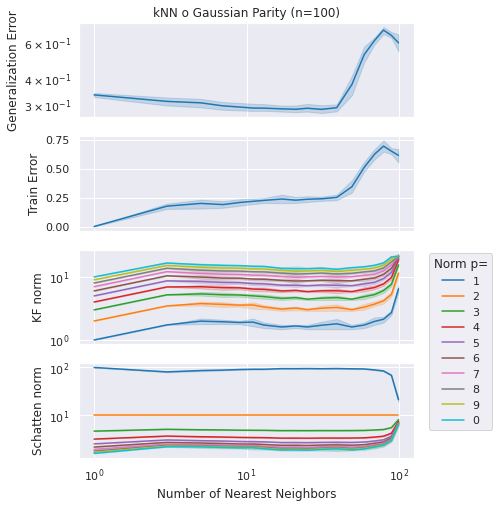

In [23]:
df = pd.DataFrame(
    df_mat,
    columns=[
        'Number of Nearest Neighbors',
        'Train Error',
        'Generalization Error',
        'Max eigenvalue',
        'Sum of eigenvalues',
    ] + [f'KF {i+1}' for i in range(10)] + [f'Schatten {i+1}' for i in range(10)]
)#.melt(var_name='Number of Fourier Features', value_name='Generalization Error')
df['Max/sum eigenvalues'] = df['Max eigenvalue'] / df['Sum of eigenvalues']

sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error']
f, axes = plt.subplots(len(metrics)+2, 1, figsize=(6, 2*len(metrics)+4), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Nearest Neighbors', y=y_label, ax=ax)
    # ax.set_yscale('log')
    
ax = axes[-2]
for metric in [f'KF {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Nearest Neighbors', y=metric, ax=ax, label=metric[-1])
ax.set_yscale('log')
ax.set_ylabel('KF norm')
ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02), title='Norm p=')

ax = axes[-1]
for metric in [f'Schatten {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Nearest Neighbors', y=metric, ax=ax)#, label=metric[-1])
ax.set_ylabel('Schatten norm')
ax.set_yscale('log')
# ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))

axes[0].set_yscale('log')
axes[2].set_yscale('log')
axes[-1].set_xscale('log')
# ax.figure.legend()
axes[0].set_title(f'kNN o Gaussian Parity (n={n})')

# plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()

In [24]:
n = 100
fall = np.logspace(np.log10(n), np.log10(1.5*n), 5).astype(int)
rise = -np.logspace(np.log10(n), np.log10(1.5*n), 5).astype(int) + 2*n
start = np.logspace(0, np.log10(0.5 * n), 10).astype(int)
ds = np.unique(np.concatenate([start, rise, fall, [5*n, 10*n, 25*n]]))

df_mat = []

n_reps = 5
X_test, y_test = generate_gaussian_parity(10000, seed=n_reps+1)

for i in range(n_reps):
    X_train, y_train = generate_gaussian_parity(n)
        
    for k in [1, 3, 5, 7, 9, 11, 13, 17, 21, 25, 31, 39, 49, 59, 69, 79, 89, 99]:
        k += 1
        knn = KNeighborsClassifier(n_neighbors=k)
        knn = knn.fit(X_train, y_train)
        indices = knn.kneighbors(X_train)[1]
        indices = np.sort(indices, axis=1)

        unique_vals, unique_idx = np.unique(indices, axis=0, return_inverse=True)
        internal_rep_mat = np.zeros((len(unique_idx), len(unique_vals)))
        internal_rep_mat[np.arange(len(unique_idx)), unique_idx] = 1
        _, singular_values, _ = svd(internal_rep_mat)

        singular_values = np.sort(singular_values)[::-1]
        s = np.sort(singular_values**2)[::-1]
        max_eval = s[0]
        sum_eval = np.sum(s)
        kf_norms = [np.sum(singular_values[:i+1]) for i in range(10)]
        schatten_norms = [np.sum(singular_values**i)**(1/i) for i in range(1,10+1)]
        
        metric = zero_one_loss # log_loss#  

        train_error = metric(y_train, knn.predict(X_train))
        test_error = metric(y_test, knn.predict(X_test))

        df_mat.append([k, train_error, test_error, max_eval, sum_eval] + kf_norms + schatten_norms)

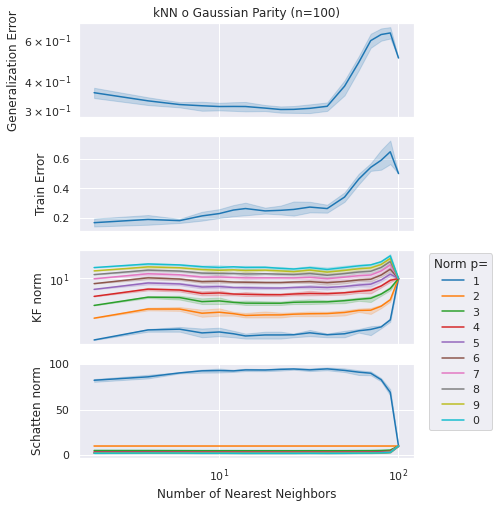

In [26]:
df = pd.DataFrame(
    df_mat,
    columns=[
        'Number of Nearest Neighbors',
        'Train Error',
        'Generalization Error',
        'Max eigenvalue',
        'Sum of eigenvalues',
    ] + [f'KF {i+1}' for i in range(10)] + [f'Schatten {i+1}' for i in range(10)]
)#.melt(var_name='Number of Fourier Features', value_name='Generalization Error')
df['Max/sum eigenvalues'] = df['Max eigenvalue'] / df['Sum of eigenvalues']

sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error']
f, axes = plt.subplots(len(metrics)+2, 1, figsize=(6, 2*len(metrics)+4), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Nearest Neighbors', y=y_label, ax=ax)
    # ax.set_yscale('log')
    
ax = axes[-2]
for metric in [f'KF {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Nearest Neighbors', y=metric, ax=ax, label=metric[-1])
# ax.set_yscale('log')
ax.set_ylabel('KF norm')
ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02), title='Norm p=')

ax = axes[-1]
for metric in [f'Schatten {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Nearest Neighbors', y=metric, ax=ax)#, label=metric[-1])
ax.set_ylabel('Schatten norm')
# ax.set_yscale('log')
# ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))

axes[0].set_yscale('log')
axes[2].set_yscale('log')
axes[-1].set_xscale('log')
# ax.figure.legend()
axes[0].set_title(f'kNN o Gaussian Parity (n={n})')

# plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()